In [65]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [66]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [68]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [69]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
yen_futures['Return'] = yen_futures.Settle.pct_change() * 100
yen_returns_df = yen_futures.dropna()
yen_returns_df.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509


### Lagged Returns

In [70]:
# Create a lagged return using the shift function
yen_returns_df['Lagged_Return'] = yen_returns_df['Return'].shift()
yen_futures_df = yen_returns_df.dropna()
yen_futures_df.tail()

<ipython-input-70-085cdf7f063d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yen_returns_df['Lagged_Return'] = yen_returns_df['Return'].shift()


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509,0.151335


### Train Test Split

In [71]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures_df[:'2017']
test = yen_futures_df['2018':]

test

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2018-01-02,8909.5,8957.5,8898.5,8938.0,26.5,8940.5,96714.0,227884.0,0.297285,0.224871
2018-01-03,8943.0,8947.5,8913.0,8921.0,21.5,8919.0,93498.0,226582.0,-0.240479,0.297285
2018-01-04,8917.0,8920.5,8891.0,8901.0,19.0,8900.0,115434.0,224918.0,-0.213028,-0.240479
2018-01-05,8897.0,8902.0,8854.0,8878.0,31.5,8868.5,133023.0,229326.0,-0.353933,-0.213028
2018-01-08,8870.5,8889.0,8849.5,8872.5,5.5,8874.0,81647.0,237100.0,0.062017,-0.353933
...,...,...,...,...,...,...,...,...,...,...
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458


,Lagged_Return
Date,
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
2014-02-25,0.020502
...,...
2017-12-22,0.084621
2017-12-26,0.118370
2017-12-27,0.118230


In [72]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
y_test = test['Return']
y_train = train['Return']
X_test = test['Lagged_Return'].to_frame()
X_train = train['Lagged_Return'].to_frame()
X_train

,Lagged_Return
Date,
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
2014-02-25,0.020502
...,...
2017-12-22,0.084621
2017-12-26,0.118370
2017-12-27,0.118230


In [73]:
y_train

Date
2014-02-19   -0.020460
2014-02-20    0.020465
2014-02-21   -0.204604
2014-02-24    0.020502
2014-02-25    0.327970
                ...   
2017-12-22    0.118370
2017-12-26    0.118230
2017-12-27   -0.151830
2017-12-28    0.180221
2017-12-29    0.224871
Name: Return, Length: 966, dtype: float64

# Linear Regression Model

In [74]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
lr_model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [75]:
# Make a prediction of "y" values using just the test dataset
predictions = lr_model.predict(X_test)
predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Predicted Return"])

In [76]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
actuals = pd.DataFrame(y_test, index=y_test.index)
actuals.columns = ["Actual Return"]

results = pd.concat([actuals, predictions], axis=1)
results.head()

,Actual Return,Predicted Return
Date,,
2018-01-02,0.297285,-0.008621
2018-01-03,-0.240479,-0.008885
2018-01-04,-0.213028,-0.006923
2018-01-05,-0.353933,-0.007024
2018-01-08,0.062017,-0.006509


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdeb9b60eb0>,
      dtype=object)

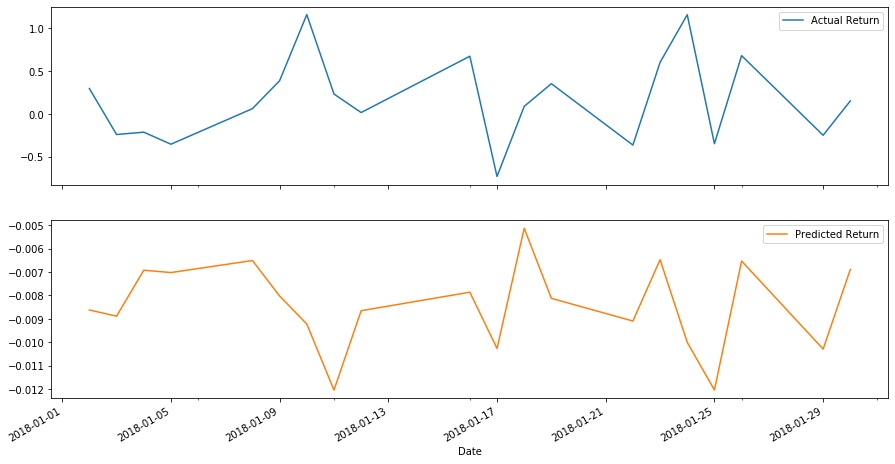

In [77]:
# Plot the first 20 predictions vs the true values
results[:20].plot(subplots=True,figsize=(15,8))

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [78]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    results["Actual Return"],
    results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_of_sample_rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.4154832784856737


In [79]:
in_sample_results = y_train.to_frame()
in_sample_results.columns = ["Out-Sample_Predictions"]


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [80]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-Sample_Predictions"] = lr_model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(in_sample_results["In-Sample_Predictions"],y_train)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")


In-sample Root Mean Squared Error (RMSE): 0.5963660785073426


# Conclusions

YOUR CONCLUSIONS HERE!

1. The graph shows that this is not a very good model. The predictions often went in opposite direction of the actual results.
2. Also the scales on the graph show that the actual vs. prediction models are different. Therefore, the magnitude of the results are different as well.
3. The RMSE showed that the out-of-sample data performed better (lower RMSE score) than the in-sample data.
4. Without more filtering, I would not trust this model to predict anything.
